# Checkpoint 2

**Due: Friday, 6 November, 2020 at 5:00pm GMT**

### Read This First
1. Use the constants provided in the cell below. Do not use your own constants.

2. Put the code that produces the output for a given task in the cell indicated. You are welcome to add as many cells as you like for imports, function definitions, variables, etc. **Additional cells need to be in the proper order such that your code runs correctly the first time through.**

3. **IMPORTANT!** Before submitting your notebook, clear the output by clicking *Restart & Clear Output* from the *Kernel* menu. If you do not do this, the file size of your notebook will be very large.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import time

from scipy.sparse.linalg import eigsh
from scipy.sparse.linalg import spsolve
from scipy.sparse import diags
from scipy.sparse import identity
from scipy import integrate
from scipy.sparse.linalg import splu
from scipy.linalg import eigh_tridiagonal


plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 16

# Task 1 (25p)

Find numerically the first 101 lowest eigenvalues (“energies”) of the discrete Hamiltonian matrix, H, for V=0 and x=0,...,L, with L=100, dx=1/8 and with reflecting boundary conditions:

$
\begin{align}
\psi_N \equiv \psi_{N-1},
\end{align}
$

$
\begin{align}
\psi_{-1} \equiv \psi_0,
\end{align}
$

Here the index -1 denotes the element to the left of the element zero, not the element N-1 as in Python. Note that indices $-1, N$ refer to elements of $\psi$ that are outside the matrix H.

Hint: The eigenvalues, $w_n$, should be

$
\large
\begin{align}
w_n = \frac{2\left(1 - \cos (\frac{n \pi}{N}) \right)}{dx^2}
\end{align}
$

for n=0, 1,..., 100. The corresponding (non-normalized) eigenvectors, $v_n$ are

$
\large
\begin{align}
v_n = \cos \left( \frac{n \pi x}{L} \right)
\end{align}
$

for x=0, dx,..., (N-1)dx.

In [2]:
### Values for task 1
L  = 100
dx = 1/8
N  = int(L/dx)
print(f"Matrix size: {N}.")

Matrix size: 800.


In the cell below, compute the 101 lowest eigenvalues given the values of V, L, and dx from above. The function, `task1` should return an array of the eigenvalues.

It may be useful to write a generalized function for creating the Hamiltonian given values of N, dx, and V.

In [3]:
# Constants
m = 1/2
hbar = 1

In [4]:
def _get_n(L,dx):
    #This function just returns N as an integer for creating arrays of this length.
    return int(L/dx)

In [5]:
def hamiltonian(N, dx, V):
    """
    Defines the hamiltonian of the system
    
    Parameters
    ----------
    N : integer
        size of hamiltonian matrix
    dx : float
        points to be integrated
    V : diagonal sparse matrix
        potential of the system
        
    Returns
    -------
    H : sparse matrix
        Hamiltonian of the system
        
    """
    diagonals = [np.full((N),  -2),
                 np.full((N-1), 1),
                 np.full((N-1), 1)]

    delta = diags(diagonals, [0, -1, 1])
    # csr because we need to keep a compressed format for faster performance
    d = delta.tocsr()
    # Take care of initial conditions
    d[0,0] = -1
    d[N-1,N-1] = -1

    H = -hbar/(2*m) * d / dx**2 + V
    return H


In [6]:
def task1():
    H = hamiltonian(N, dx, V=0).toarray()
    # Array of diagonal values
    Q = np.diag(H)
    # Array of of-diagonal values
    W = np.diag(H, k=1)
    # select = 'i' are the eigenvalues with indices min <= i <= max
    # select_range = find 101 smallest eigenvalues
    w, _ = eigh_tridiagonal(Q, W, select = 'i', select_range = (0,100))
    return w

## Testing task 1

The cell below will run your function and compare it with the expected values.

Time to solution: 0.035470008850097656 seconds.


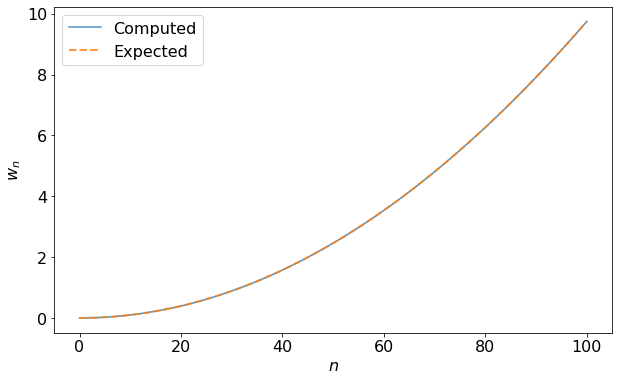

Max difference is 1.7702117765407015e-11.


In [7]:
t1 = time.time()
ww = task1()
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")

my_n = np.arange(101)
ww_expected = 2 * (1 - np.cos(my_n*np.pi/N)) / dx**2

plt.plot(my_n, ww, label='Computed', alpha=0.8)
plt.plot(my_n, ww_expected, label='Expected', linewidth=2, linestyle='--', alpha=0.8)
plt.xlabel(r'$n$')
plt.ylabel(r'$w_{n}$')
plt.legend()
plt.show()

diff = np.abs(ww - ww_expected) / np.max(np.abs([ww, ww_expected]), axis=0)
print (f"Max difference is {diff[1:].max()}.")
assert (diff[1:] < 1e-6).all()

# Task 2 (5p)

Select dx as a negative power of two ($dx=2^{-n}$ for n>0) such that the 101th eigenvalue differs from the dx$\rightarrow$0 limiting value of

$
\begin{align}
w_{101,exact} = \frac{(100\pi/N)^{2}}{dx^2}
\end{align}
$

by less than 0.1%, i.e., $|w_{101}/w_{101,exact}-1|<0.001$.

Motivation: selecting a sufficiently small dx is required to obtain a good approximation to the original (continuous) equation (1) for subsequent tasks.

In the cell below, compute a value of dx that satisfies the above contraint. The function `task2` should return the value of dx that you have calculated.

In [8]:
def task2():
    """"
    Computes the value of dx that satisfies the above contraint
    """
    # list of trial n powers. 
    # Chose list instead of array because it only consitutes a few elements (9)
    n_powers = [1,2,3,4,5,6,7,8,9,10]
    for i in n_powers:
        dx = 2**(-i)
        N  = int(L/dx)
        # the exact value
        exact = (np.pi * 100 / N)**2 / dx**2
        # Same as task 1 with range to take only the 101st eigenvalue
        H = hamiltonian(N, dx, V=0).toarray()
        Q = np.diag(H)
        W = np.diag(H, k=1)
        w, v = eigh_tridiagonal(Q, W, select = 'i', select_range = (100,101))
        if abs(w[0]/exact - 1) < 0.001:
            final_dx = dx
            return final_dx

## Testing task 2

The cell below will run the `task2` function. We will verify that value of dx return satisfies the criterion outlined above.

In [9]:
t1 = time.time()
my_dx = task2()
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")


Time to solution: 0.026443958282470703 seconds.


# Task 3 (20p)

Solve equation (1) with the initial condition (2) (the Schroedinger equation and the Gaussian function from the checkpoint's description) for V(x)=0, on a domain x=0...100, for t=0...4 and dx from task 2. Plot $|\psi(x,t)|^2$ and determine its mean given by

$
\large
\begin{align}
<x>\ = \int_{0}^{100} |ψ(x)|^2 x dx.
\end{align}
$

The mean should be equal to 79$\pm$-1.

Hint: use the procedure for creating the Hamiltonian matrix from tasks 1, 2. This will reduce the amount of coding required.

In [10]:
### Constants for task 3 and 4
x0     = 15
v      = 16
sigma2 = 5
tmax   = 4

## Task 3 plot and result

In the cell(s) below, do the following:
1. Solve equation (1) for t=0...4 and plot $|\psi(x,t=0)|^2$ and $|\psi(x,t=tmax)|^2$ as a function of x.
2. Compute the mean of the final position and print the value. The correct result should be between 78 and 80.

Don't forget to nomalize your Gaussian initial condition so that the total probability $\int_0^L |\psi(x,t=0)|^2 dx=1$. 

You do not have to wrap up the calculation in a function "task3()", but doing so may help to reduce the amount of coding for tasks 4-6.

In [11]:
def my_gaussian(x, x0, v, sigma2):
    """
    Compute the Gaussian function.
    
    Parameters
    ----------
    x : float or array
        A single value or an array of values for which the Gaussian will be evaluated.
    x0 : float
        mean of the Gaussian distribution
    v : float
        velocity
    sigma2 : float
        variance of the Gaussian distribution
        
    Returns
    -------
    y : array
        values of the Gaussian distribution for all values of x
    """
    return np.exp(-(x - x0)**2 / (2*sigma2)+ 0.5j * x * v) 

def amplitude(x):
    """
    Compute the ψ.ψ*
    
    Parameters
    ----------
    x : array
        array of the function that we need the amplitude of

    Returns
    -------
    absolute value of function array
    
    """
    return (np.conj(x) * x).real

def get_mean(amp, x):
    """
    Compute the mean of a function (integrate and 
    calculate the area underneath with simpsons rule).
    
    Parameters
    ----------
    amp : array
        function to integrate over.
    x : array
        array of x's
    
    """
    mean = integrate.simps(x * amp,x)
    print('Mean is {}'.format(mean))

def plot_psi2(x, psi0_2, psi_final_2):
    """
    plots ψψ* against position
    
    Parameters
    ----------
    psi0_2 : array
        ψψ*(t=0)
    psi_final_2: array
        ψψ*(t=final)
    x : array
        array of x's
    
    """

    fig, ax = plt.subplots(figsize=(16, 9))
    
    ax.plot(x, psi0_2, linestyle='-', linewidth=2, color='red', label = '$|\psi(x,t=0)|^2$')
    ax.plot(x, psi_final_2, linestyle='-', linewidth=2, color='blue', label = '$|\psi(x,t=tmax)|^2$')
    ax.xaxis.set_label_text('x values', fontsize=14)
    ax.yaxis.set_label_text('Amplitude', fontsize=14)
    ax.legend()
    plt.show()

In [12]:
def wavefunction(x, V, dx, v):
    """
    Finds the wavefunction, solves the S.E.
    
    Parameters
    ----------
    x : array
        array x's in space
    V : sparse matrix
        potential of the system
    dx : float
        increments to create Hamiltonian
    v : velocity for initial ψ

    Returns
    -------
    psi0_N : complex array
        wavefunction at t=0
    psi : complex array
        wavefunction at t=final
    list_psi : complex array
        array of all psi's
    
    """
    
    psi0 = my_gaussian(x, x0, v, sigma2)
    psi2 = amplitude(psi0)

    # Normalize integral
    integral = integrate.simps(psi2,x)
    Normal = np.sqrt(1. / integral).real

    dt = 1 / 512
    # Normalized psi0
    psi0_N = Normal * psi0
    N = _get_n(L, dx)
    H = hamiltonian(N, dx, V)
    iden = identity(H.shape[0])
    
    # Computes the LU decomposition of the  Matrix.
    # A and B were calculated as given in the lectures.
    A = splu((iden + (0.5j * dt  * H)).tocsc())
    B = (iden - (0.5j * dt  * H)).tocsc()
    
    psi = psi0_N.copy()

    # evolve to t = 4
    nmax = int(tmax / dt)
    
    # this is only for task 5 onwards
    list_psi = np.empty((nmax, len(psi)), dtype=complex)
    
    for n in range(nmax):
        list_psi[n] = psi 
        # Solves matrix equation
        psi = A.solve(B * psi)
        # take last value
        if (abs(n-nmax) == 1):
            list_psi[n] = psi
            
    return psi0_N, psi, list_psi 

Time to solution: 0.3103041648864746 seconds.


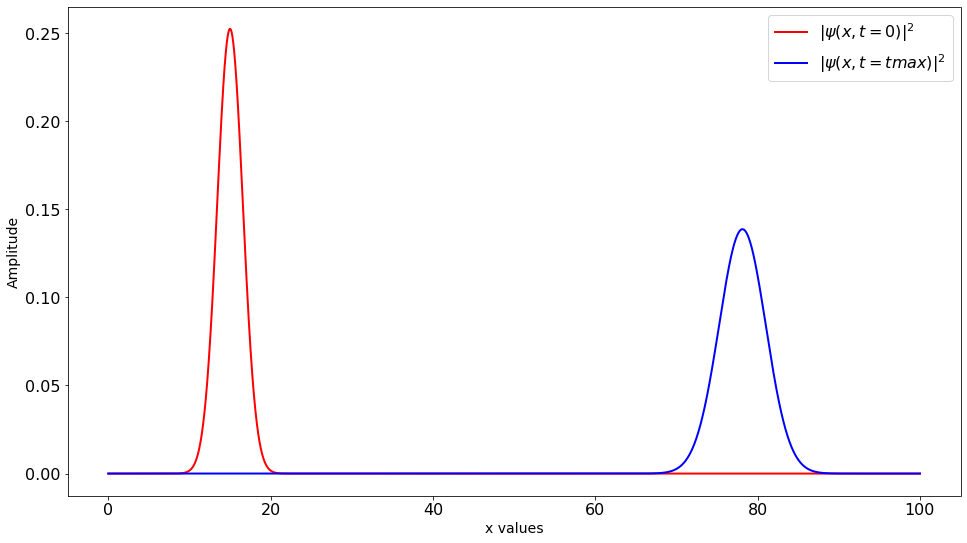

Mean is 78.12345655577994


In [13]:
#create our x values up to 100, with dx = my_dx
x = np.linspace(0,L, _get_n(L, my_dx))

t1 = time.time()
psi_init, psi_final, _ = wavefunction(x, 0, my_dx, v)
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")

# find ψψ*(t=0) and ψψ*(t=4)
psi_final_2 = amplitude(psi_final)
psi0_2 = amplitude(psi_init)

# plot and get mean
plot_psi2(x, psi0_2, psi_final_2)
get_mean(psi_final_2,x)

# Task 4 (10p)

Now repeat task 3 for a potential made up of regularly spaced wells such that

V=70 for |x-i| < 0.25 where i=0,1,...,100,

and V=0 elsewhere.

Plot the potential. It should be $V=70$ for $x=0...0.25$, $V=0$ for $x=0.25...0.75$, $V=70$ for $x=0.75...1.25$, and so on.

Determine the mean of $|\psi(x,t)|^2$ as before, with accuracy $\pm$1.

Make sure that dx and dt are sufficiently small to achieve this accuracy!

In the cell below, create the potential and plot it over the range [0, 3].

In [14]:
def isInt(num):
    # return True if we have an integer
    return np.equal(np.mod(num, 1), 0)

def get_V(L,dx, rand=False):
    """
    Calculates the potential
    
    Parameters
    ----------
    L : integer
        length of x array
    dx : float
        increments of x to be used. The smaller the dx, 
        the more sharply vertical our potential will be.
    rand : boolean
        choose to have random widths for the potential (task 7)

    Returns
    -------
    V : array
        potential at given x
    potential : compressed sparse matrix
        potential in diagonal sparse form
    x : array
        array of x values with given dx
    
    """
    
    start, stop = 0, L - dx
    x = np.arange(start, stop + dx, dx)
    V = np.zeros(x.shape[0])
        
    for i, num in enumerate(x):
        if rand:
            # This is for Task 7
            b = np.random.uniform(0.125,0.375)
        else:
            b = 0.25
        width = int(b/dx)
        if isInt(num):
            left = np.maximum(0, i - width)
            V[left:i+width] = 70
    potential = diags([V], [0]).tocsc()
    
    return V, potential, x


def plot_V(rand):
    "Plots the potential up to x=3 with a small enough dx"
    
    dx = 1/128
    V, _ , x = get_V(3+dx, dx, rand)

    fig, ax = plt.subplots(figsize=(13, 6))
    
    ax.plot(x, V, linestyle='-', linewidth=2, color='red')
    ax.xaxis.set_label_text('x values', fontsize=16)
    ax.yaxis.set_label_text('Potential', fontsize=16)
    plt.show()


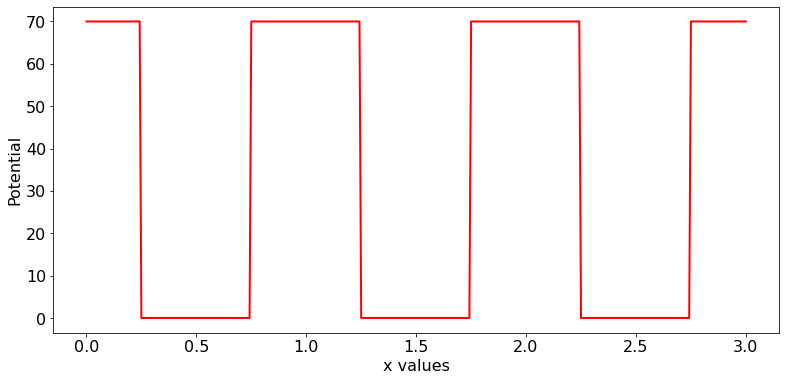

In [15]:
plot_V(rand = False)

# Task 4 continued

In the cell below, repeat task 3 with the new potential.

Time to solution: 0.9789268970489502 seconds.


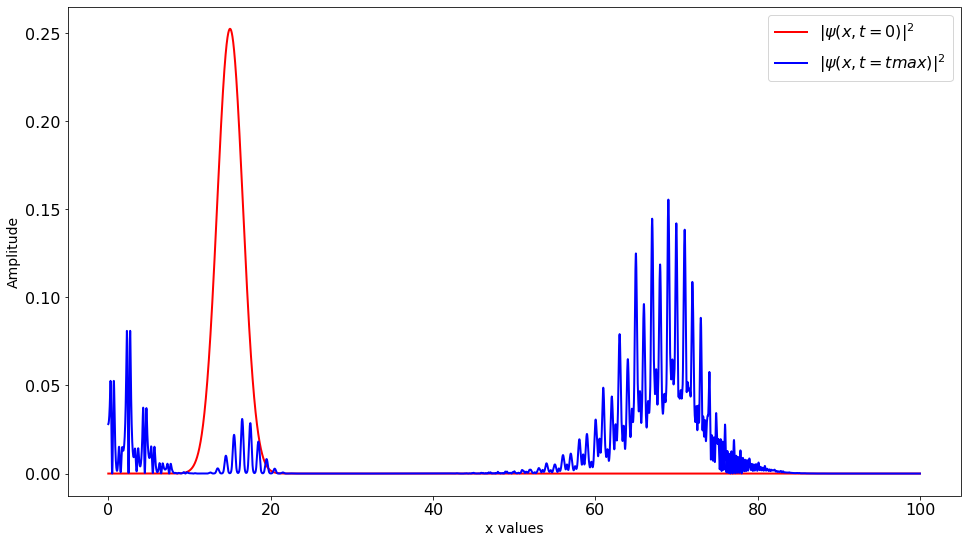

Mean is 57.51289496125949


In [16]:
# Here I use a very small dx since it has a small impact (1s) on the computation time
# and gives a more accurate result
dx = 1/128
V, potential , x = get_V(L, dx, rand = False)
t1 = time.time()

psi_init, psi_final, list_psi = wavefunction(x, potential, dx, v)
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")

# find ψψ*(t=0) and ψψ*(t=4)
psi_final_2 = amplitude(psi_final)
psi0_2 = amplitude(psi_init)

plot_psi2(x, psi0_2, psi_final_2)
get_mean(psi_final_2,x)

# Task 5 (15p)

Calculate the probability $P_{1/2}$ of the particle moving through the point x=L/2 by integrating the probability current 

$
\large
\begin{align}
j = (\psi^*  \frac{\partial \psi}{\partial x} -
\psi \frac{\partial \psi^*}{\partial x})(x=L/2)
\end{align}
$

over time, for t=0...4. The probability can deviate from the true value by no more than $\pm$0.01 (hint: the correct value is between 0.5 and 1).

In the cell below, calculate the probability and print your answer.

In [17]:
def get_current(list_psi):
    """
    Calculates the probability current
    
    Parameters
    ----------
    list_psi :array
        array of ψ(x,t)

    Returns
    -------
    current : array
        probability current
    
    """
    
    
    # array of ψ*'s
    list_psi_star = np.conj(list_psi)
    
    # Find corresponding element at L/2
    L2_index = np.where(x==(L/2))[0][0]
    
    # I create these arrays to find ψ(x=L/2, t), ψ(x=L/2 +1 , t) in order to
    # differentiate discretely.
    new_psi = list_psi[:,L2_index]
    new_psi2 = list_psi[:,L2_index + 1]
    new_psi_star = list_psi_star[:,L2_index]
    new_psi_star2 = list_psi_star[:,L2_index + 1]
    
    current = -1j*(new_psi_star * (new_psi2 - new_psi)/dx \
                   - new_psi*(new_psi_star2 - new_psi_star)/dx)
    return current

In [18]:
def task5(prt):
    """
    P of the particle moving through the point x=L/2
    
    Parameters
    ----------
    prt : boolean
        True if print statement is needed for this function

    Returns
    -------
    integral: float
        $P_{1/2}$
    
    """

    dt = 1/512
    
    # integration with respect to t
    list_t = np.linspace(0,4, int(4 /dt))
    integral = integrate.simps(current,list_t)

    if prt == True:
        print('P of the particle moving through the point x=L/2 is: {}'.format(integral.real))
    return (integral.real)

In [19]:
t1 = time.time()
current = get_current(list_psi)
probability = task5(prt = True)
t2 = time.time()
print (f"Time to solution: {t2-t1} seconds.")

P of the particle moving through the point x=L/2 is: 0.8381700919998939
Time to solution: 0.2905910015106201 seconds.


# Task 6 (15p)

Plot the probability $P_{1/2}$ as a function of particle energy E=0...100, for at least 100 equally-spaced values from this range. All $P_{1/2}$ values should be within $\pm$0.01 of the true values. Use the formula 

$
\large
\begin{align}
E = \frac{1}{4} v^2
\end{align}
$

to convert between energy and velocity (valid for Eqs. (1,2)).

Bonus question: can you explain why the plot looks like this?

Plot the probability in the cell below.

In [20]:
# create Energy linspace
E = np.linspace(0,L,L)
# velocities array
velocities = 2 * np.sqrt(E)
# Probabilities for each E
probabilities = np.empty(len(E))

# dx small enough to get probabilities within $\pm$ 0.01. 
# Could increase it to decrease runtime
dx = 1/64

t3 = time.time()
for i, vel in enumerate(velocities):
    _, potential , x = get_V(L, dx , rand = False)
    t1 = time.time()
    # Gets the velocity from the array of velocities
    _, _, list_psi = wavefunction(x, potential, dx, v = vel)
    current = get_current(list_psi)
    # Exactly as task 5 without printing each individual probability
    probabilities[i] = task5(prt = False)
t4 = time.time()
print (f"Time to solution: {t4-t3} seconds.")


Time to solution: 63.34963893890381 seconds.


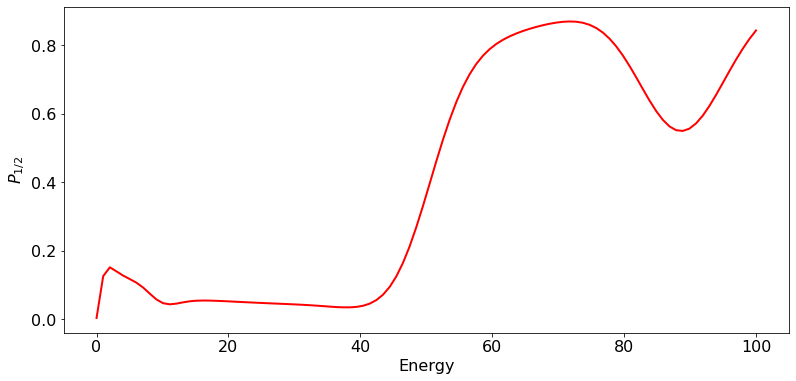

In [21]:
def plot_probs():
    "Plots the probabilities for each Energy at x=L/2"
    
    fig, ax = plt.subplots(figsize=(13, 6))
    ax.plot(E, probabilities, linestyle='-', linewidth=2, color='red')
    ax.xaxis.set_label_text('Energy', fontsize=16)
    ax.yaxis.set_label_text('$P_{1/2}$', fontsize=16)
    plt.show()
    
plot_probs()

# Task 7 (10p)

Assume again the initial condition of equation (2) with v=16, and consider a disordered potential in which

V=70 for |x-i| < b$_i$ where i=0,1,...,100,

and b$_i$ is a random variable uniformly distributed on [0.125, 0.375].

Find the probability $P_{1/2}$ by averaging over 100 realizations of the random potential (must be accurate to $\pm$0.02). Plot the histogram of $P_{1/2}$. Comment on the value of $P_{1/2}$ compared with task 5.

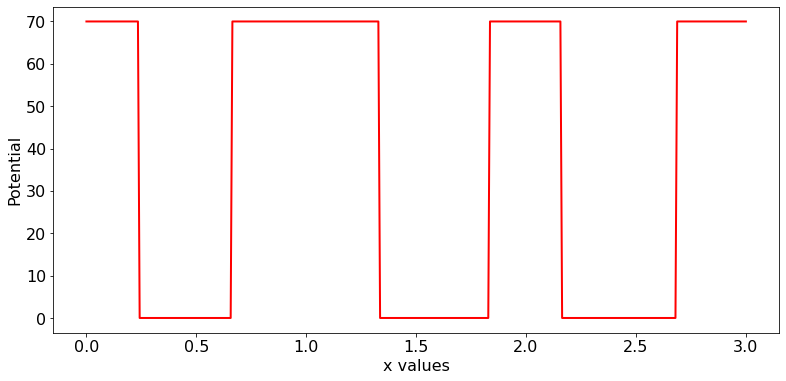

In [22]:
# Plotting the V with randomm widths to make sure it works fine
plot_V(rand = True)

In [23]:
t1 = time.time()
# Empty array of probabilities
probs = np.empty(L)
dx = 1/32
for i in range(L):
    # rand=True means we have a varying potential width
    # Now with v=16 the same calculation is done as task6
    _, potential, x = get_V(L, dx, rand = True)
    _, _, list_psi = wavefunction(x, potential, dx, v=16)
    current = get_current(list_psi)
    probs[i] = task5(prt = False)
t2 = time.time()

In [24]:
print('The Mean is: {}'.format(np.mean(probs)))
print (f"Time to solution: {t2-t1} seconds.")

The Mean is: 0.05731813080607886
Time to solution: 27.875541925430298 seconds.


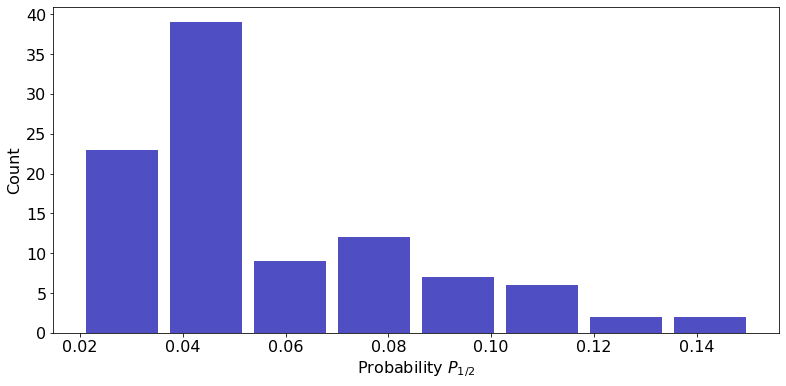

In [25]:
#plot of the histogram
fig, ax = plt.subplots(figsize=(13, 6))

ax.hist(probs, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=0.85)
ax.xaxis.set_label_text('Probability $P_{1/2}$', fontsize=16)
ax.yaxis.set_label_text('Count', fontsize=16)
plt.show()

Comparing with task 5 we can easily conclude that the probability of the
particle moving from x = L/2 has dramatically decreased by a factor of >10.
This shows that the random-varying potential was able to localize the particle.
This usually happens when different wavelengths of the wavepacket superpose.
Obviously, a potential with regular widths was not able to trap the particle.